In [1]:
from openhsl.models.ssftt import SSFTT
from openhsl.hsi import HSImage
from openhsl.hs_mask import HSMask
from openhsl.data.utils import apply_pca, convert_to_color_, sample_gt
from openhsl.utils import draw_fit_plots

from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from scipy.io import loadmat

import cv2
import numpy as np
import pandas as pd

# Простой пример с ГСИ таблеток

Данный ГСИ представляет собой набор двух видов таблеток, неразличимых в RGB - белый уголь и мел.

Датасет доступен для скачивания по ссылке: https://storage.ai.ssau.ru/s/27ff2tYjf9nxEKx?path=%2Fdata%2Fdata%2Ftablet

Зададим пути к ГСИ и соответствующей эталонной маске

In [2]:
path_to_hsi = './test_data/tr_pr/tablet.mat'

path_to_mask = './test_data/tr_pr/tablet_gt.mat'

Создадим объект ГСИ с помощью HSImage. Загрузим в него данные с помощью метода load(), указав ключ для .mat файла

In [3]:
hsi = HSImage()
hsi.load(path_to_hsi, key='image')

Metainfo file does not exist!


Для снижения спектральной размерности применим PCA

In [4]:
hsi.data, pca_tablet = apply_pca(hsi.data, num_components=30)

Will apply PCA from 250 to 30


Создадим объект маски с помощью HSMask. Загрузим в него данные с помощью метода load, указав ключ для .mat файла

In [5]:
mask = HSMask()
mask.load(path_to_mask, key='img')

void mask


Отрисуем маску для наглядности. 

Объект маски хранится как трехмерное изображение, где каждый слой представляет собой бинарную маску наличия/отсутствия соответствующего класса. Поэтому для корректного отображения маски в градациях серого требуется вызвать у объекта маски метод get_2d().

Для большей наглядности раскрасим маску с помощью convert_to_color_()

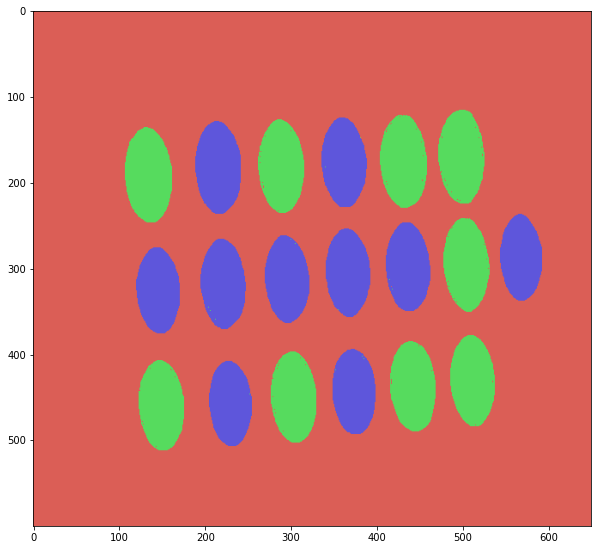

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(convert_to_color_(mask.get_2d()))
plt.show()

Создадим объект модели SSFTT с заданными параметрами.

Требуется указать количество классов, количество каналов входного ГСИ и устройство, на котором будем запускать данную модель.

In [7]:
ssftt = SSFTT(n_classes=mask.n_classes, # количество классов можно вытащить из объекта маски
              n_bands=30, # количество каналов входного ГСИ
              device='cuda')

Зададим параметры обучения.

Уделим внимание только параметру dataloader_mode. Он может принимать три значения: 

- "random" данные с маски берутся случайно с заданной вероятность (параметр train_sample_percentage).
- "fixed" данные с маски берутся в равном соотношении, т.е. каждый класс в обучающей выборке будет количестве train_sample_percentage от общего количества данных в классе.
- "disjoint" данные с маски берутся без точечного разбиения.

Примеры приведены ниже:

Sampling fixed with train size = 0.3


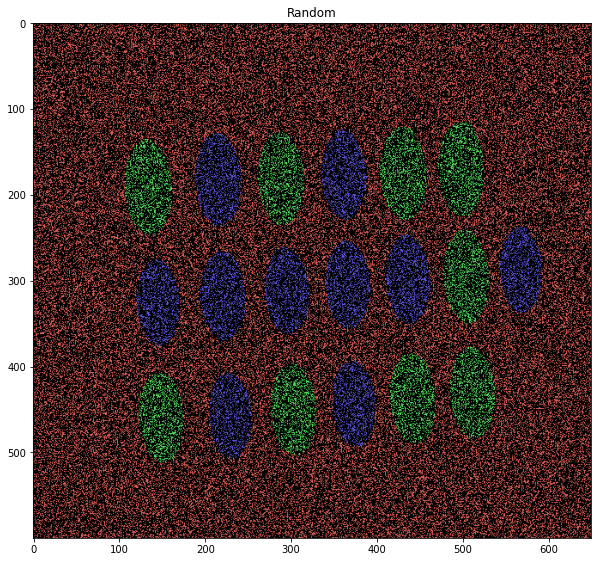

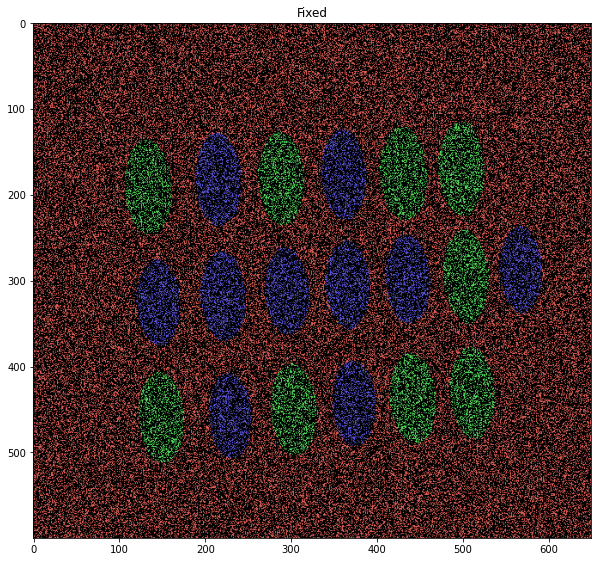

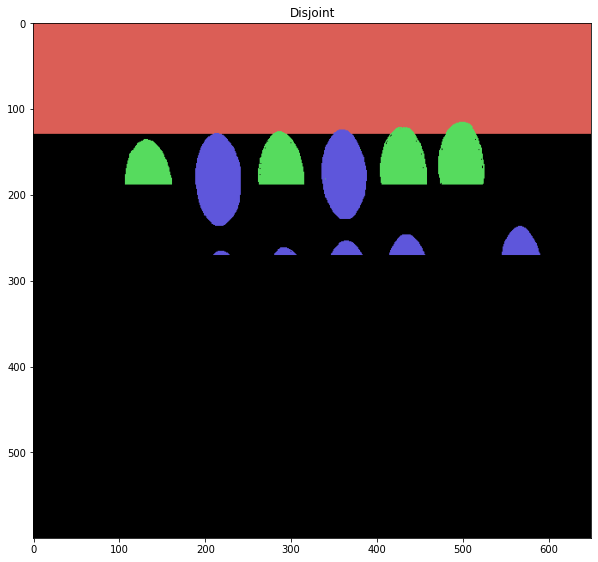

In [8]:
random, _ = sample_gt(mask.get_2d(), train_size=0.3, mode='random')
fixed, _ = sample_gt(mask.get_2d(), train_size=0.3, mode='fixed')
disjoint, _ = sample_gt(mask.get_2d(), train_size=0.3, mode='disjoint')


plt.figure(figsize=(10,10))
plt.imshow(convert_to_color_(random))
plt.title("Random")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(convert_to_color_(fixed))
plt.title("Fixed")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(convert_to_color_(disjoint))
plt.title("Disjoint")
plt.show()

In [9]:
optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}


fit_params = {
    "epochs": 5,
    "train_sample_percentage": 0.1,
    "dataloader_mode": "random",
    "optimizer_params": optimizer_params,
    "batch_size": 256,
}

Запустим обучение с помощью метода fit(), передав параметры обучения

In [10]:
ssftt.fit(X=hsi, 
          y=mask, 
          fit_params=fit_params)

PCA will not apply


Train loop: 100%|█| 5/5 [00:41<00:00,  8.24s/it, train accuracy: 0.9948268173034042	val accuracy: 0.9914047810905184	tr


Отрисуем графики обучения

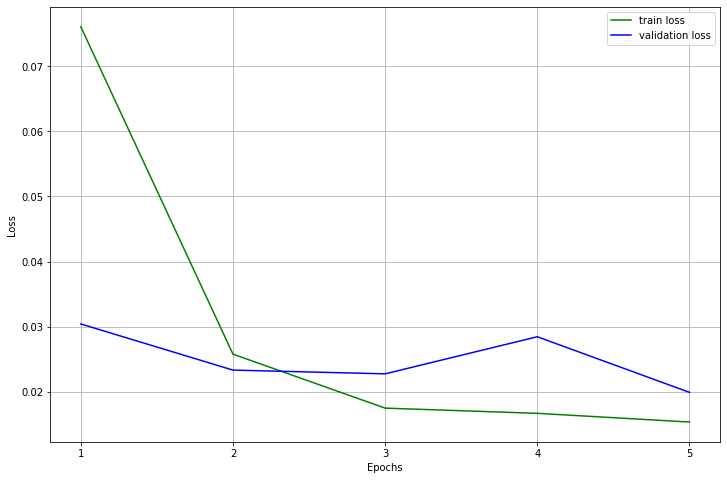

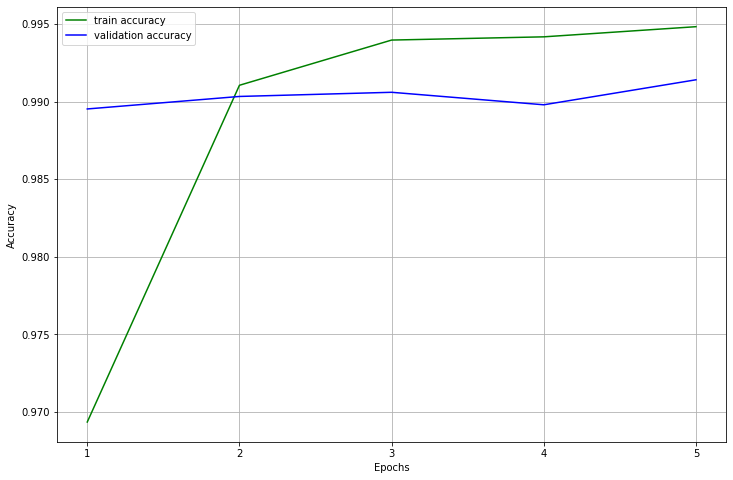

In [11]:
draw_fit_plots(ssftt)

Получим предсказание на всём ГСИ, не учитывая неразмеченные области на эталонной маске

In [12]:
pred = ssftt.predict(X=hsi, y=mask)

pred = pred * (mask.get_2d() > 0)

PCA will not apply


Inference on the image: 5862it [00:16, 359.99it/s]                                                                     


Отрисуем для наглядности результаты предсказания и эталонную маску

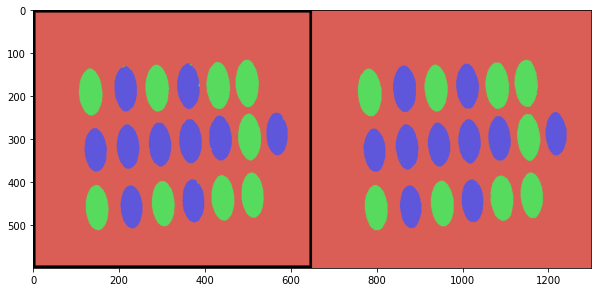

In [13]:
color_pred = convert_to_color_(pred)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred, convert_to_color_(mask.get_2d()))))
plt.show()

Удалим из предсказания данные обучения и получим чистые тестовые данные. 

Маски обучения сохраняются в папку "./masks/model_class_name/model_name"

In [14]:
train_mask = cv2.imread('./masks/ssftt__net/ssftt/2023_09_08_10_39_34_color_mask.png', 0)
pred_clear = pred * (train_mask == 0)
gt_clear = mask.get_2d() * (train_mask == 0)

Получим метрики классификации для чистых тестовых данных

In [15]:
report = classification_report(pred_clear.flatten(), gt_clear.flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score        support
0              1.000000  0.722118  0.838640   48607.000000
1              0.948218  0.995978  0.971511  267546.000000
2              0.983758  0.986877  0.985315   36578.000000
3              0.985531  0.983284  0.984406   37269.000000
accuracy       0.959779  0.959779  0.959779       0.959779
macro avg      0.979377  0.922064  0.944968  390000.000000
weighted avg   0.961570  0.959779  0.957478  390000.000000

Очистим память от загруженных данных

In [16]:
del(hsi)
del(mask)
del(ssftt)
del(pred)
del(color_pred)
del(train_mask)
del(gt_clear)
del(pred_clear)
del(report)

# Пример с ГСИ, имеющими различные условия освещения

Зададим пути к ГСИ и их маскам.

ГСИ доступны по ссылке: https://storage.ai.ssau.ru/s/27ff2tYjf9nxEKx?path=%2Fdata%2Fdata%2Fcorn_fields

In [17]:
path_to_hsi_1 = './test_data/tr_pr/corn_1.mat'
path_to_hsi_2 = './test_data/tr_pr/corn_2.mat'
path_to_hsi_3 = './test_data/tr_pr/corn_3.mat'

path_to_mask_1 = './test_data/tr_pr/mask_corn_1.mat'
path_to_mask_2 = './test_data/tr_pr/mask_corn_2.mat'
path_to_mask_3 = './test_data/tr_pr/mask_corn_3.mat'

Создадим объекты ГСИ с помощью HSImage

In [18]:
hsi_1 = HSImage()
hsi_1.load(path_to_hsi_1, key='image')

hsi_2 = HSImage()
hsi_2.load(path_to_hsi_2, key='image')

hsi_3 = HSImage()
hsi_3.load(path_to_hsi_3, key='image')

Metainfo file does not exist!
Metainfo file does not exist!
Metainfo file does not exist!


Применим понижение спектральной размерности с помощью PCA

In [19]:
hsi_1.data, pca_1 = apply_pca(hsi_1.data, num_components=30)

Will apply PCA from 250 to 30


Так же примением полученный базис PCA к другим ГСИ

In [20]:
hsi_2.data, _ = apply_pca(hsi_2.data, pca=pca_1)
hsi_3.data, _ = apply_pca(hsi_3.data, pca=pca_1)

Will apply PCA from 250 to 30
Will apply PCA from 250 to 30


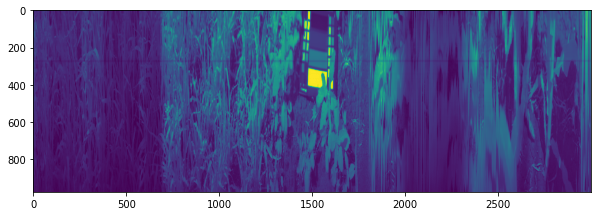

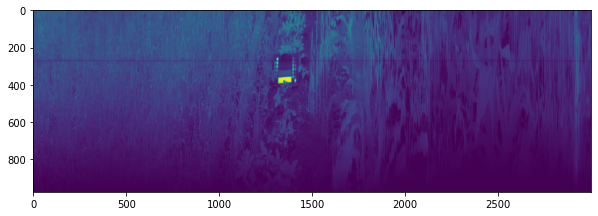

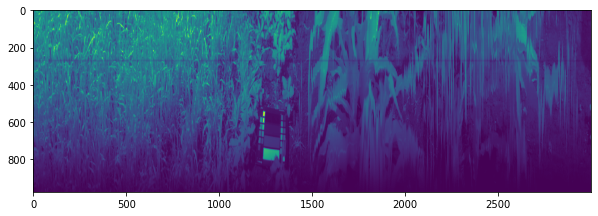

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_1[0])
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(hsi_2[0])
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(hsi_3[0])
plt.show()

Загрузим маски соответствующие ГСИ

Выводимые сообщения "void mask" появляются при создании объекта маски через пустой конструктор

In [21]:
mask_1 = HSMask()
mask_1.load(path_to_mask_1, key='img')

mask_2 = HSMask()
mask_2.load(path_to_mask_2, key='img')

mask_3 = HSMask()
mask_3.load(path_to_mask_3, key='img')

void mask
void mask
void mask


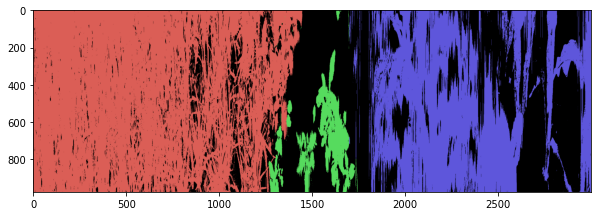

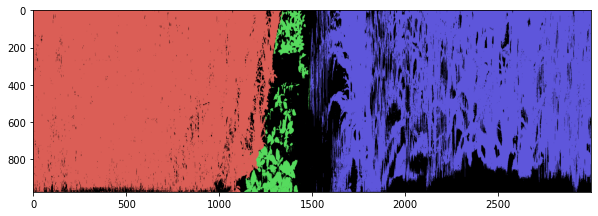

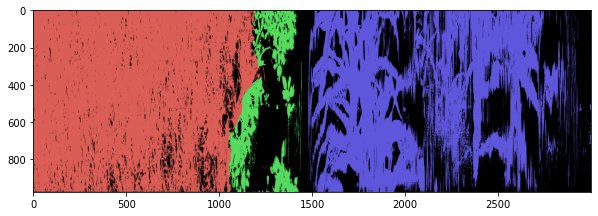

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(convert_to_color_(mask_1.get_2d()))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(convert_to_color_(mask_2.get_2d()))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(convert_to_color_(mask_3.get_2d()))
plt.show()

### ГСИ 1

In [23]:
optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}


fit_params = {
    "epochs": 5,
    "train_sample_percentage": 0.1,
    "dataloader_mode": "fixed",
    "optimizer_params": optimizer_params,
    "batch_size": 256,
}

In [24]:
ssftt_1 = SSFTT(n_classes=mask_1.n_classes, # количество классов можно вытащить из объекта маски
                n_bands=30, # количество каналов входного ГСИ
                device='cuda')

In [25]:
ssftt_1.fit(X=hsi_1, 
            y=mask_1, 
            fit_params=fit_params)

PCA will not apply
Sampling fixed with train size = 0.1
Sampling fixed with train size = 0.9


Train loop: 100%|█| 5/5 [03:23<00:00, 40.63s/it, train accuracy: 0.9988110423003446	val accuracy: 0.9985982036239032	tr


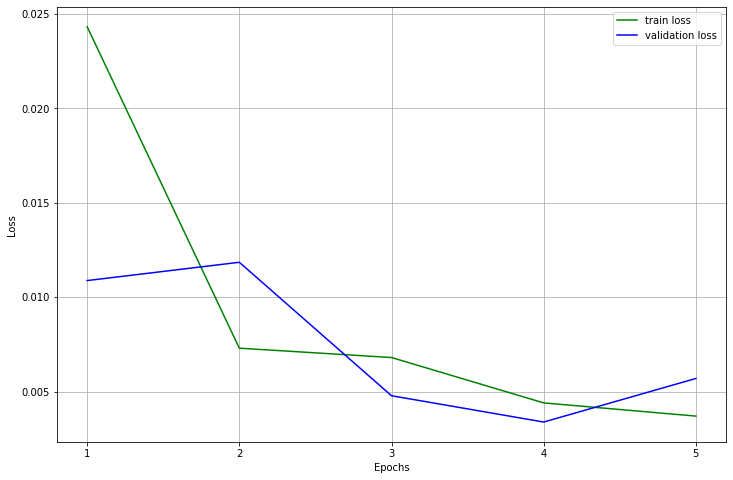

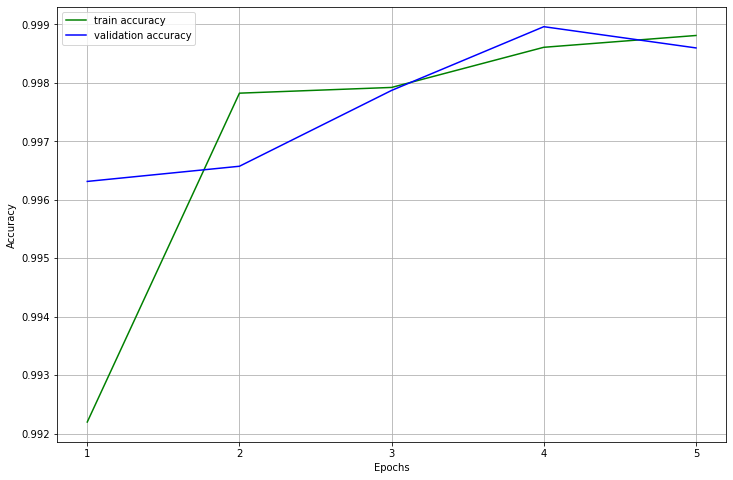

In [26]:
draw_fit_plots(ssftt_1)

#### Предсказание на ГСИ 1

In [32]:
pred_1_1 = ssftt_1.predict(X=hsi_1)

pred_1_1 = pred_1_1 * (mask_1.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:03, 363.88it/s]                                                                    


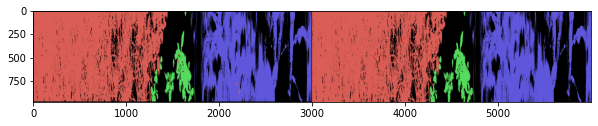

In [33]:
color_pred_1_1 = convert_to_color_(pred_1_1)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_1_1, convert_to_color_(mask_1.get_2d()))))
plt.show()

In [38]:
report = classification_report(pred_1_1.flatten(), mask_1.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.965322  0.982355  9.997610e+05
1              0.982383  0.997203  0.989737  1.153102e+06
2              0.973454  0.994449  0.983840  9.565500e+04
3              0.977983  0.999876  0.988809  6.794820e+05
accuracy       0.986848  0.986848  0.986848  9.868477e-01
macro avg      0.983455  0.989213  0.986185  2.928000e+06
weighted avg   0.987085  0.986848  0.986808  2.928000e+06

#### Предсказание на ГСИ 2

In [34]:
pred_1_2 = ssftt_1.predict(X=hsi_2)

pred_1_2 = pred_1_2 * (mask_2.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:04, 361.70it/s]                                                                    


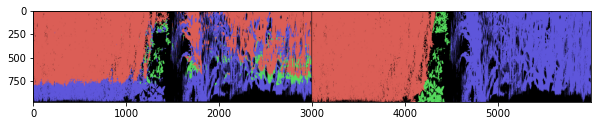

In [35]:
color_pred_1_2 = convert_to_color_(pred_1_2)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_1_2, convert_to_color_(mask_2.get_2d()))))
plt.show()

In [39]:
report = classification_report(pred_1_2.flatten(), mask_2.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.951197  0.974988  6.359390e+05
1              0.775069  0.659664  0.712725  1.384580e+06
2              0.306319  0.206684  0.246826  1.162690e+05
3              0.476258  0.641798  0.546773  7.912120e+05
accuracy       0.700167  0.700167  0.700167  7.001673e-01
macro avg      0.639411  0.614836  0.620328  2.928000e+06
weighted avg   0.724563  0.700167  0.706342  2.928000e+06

#### Предсказание на ГСИ 3

In [36]:
pred_1_3 = ssftt_1.predict(X=hsi_3)

pred_1_3 = pred_1_3 * (mask_3.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:03, 364.54it/s]                                                                    


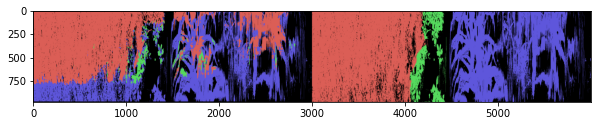

In [37]:
color_pred_1_3 = convert_to_color_(pred_1_3)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_1_3, convert_to_color_(mask_3.get_2d()))))
plt.show()

In [40]:
report = classification_report(pred_1_3.flatten(), mask_3.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.972407  0.986010  9.895140e+05
1              0.757559  0.763900  0.760716  1.008110e+06
2              0.274312  0.513574  0.357614  6.560100e+04
3              0.703760  0.672548  0.687800  8.647750e+05
accuracy       0.801776  0.801776  0.801776  8.017756e-01
macro avg      0.683908  0.730607  0.698035  2.928000e+06
weighted avg   0.812775  0.801776  0.806287  2.928000e+06

### ГСИ 2

In [62]:
optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}


fit_params = {
    "epochs": 5,
    "train_sample_percentage": 0.1,
    "dataloader_mode": "fixed",
    "optimizer_params": optimizer_params,
    "batch_size": 256,
}

In [63]:
ssftt_2 = SSFTT(n_classes=mask_2.n_classes, # количество классов можно вытащить из объекта маски
                n_bands=30, # количество каналов входного ГСИ
                device='cuda')

In [64]:
ssftt_2.fit(X=hsi_2, 
            y=mask_2, 
            fit_params=fit_params)

PCA will not apply
Sampling fixed with train size = 0.1
Sampling fixed with train size = 0.9


Train loop: 100%|█| 5/5 [03:59<00:00, 47.81s/it, train accuracy: 0.9958519122975743	val accuracy: 0.995280751584007	tra


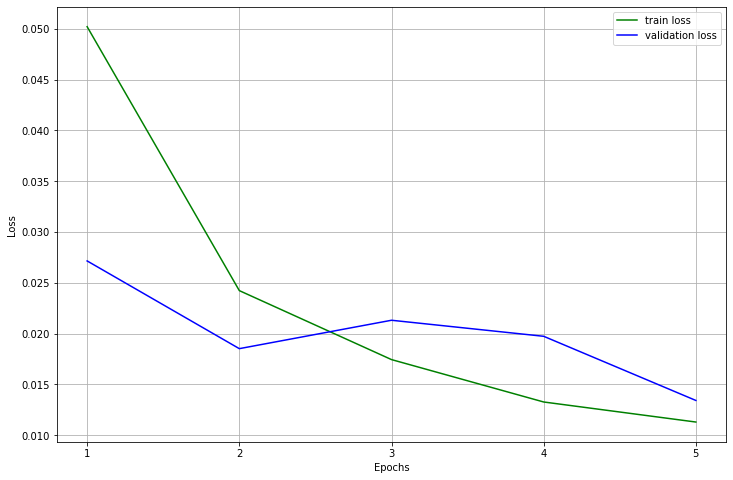

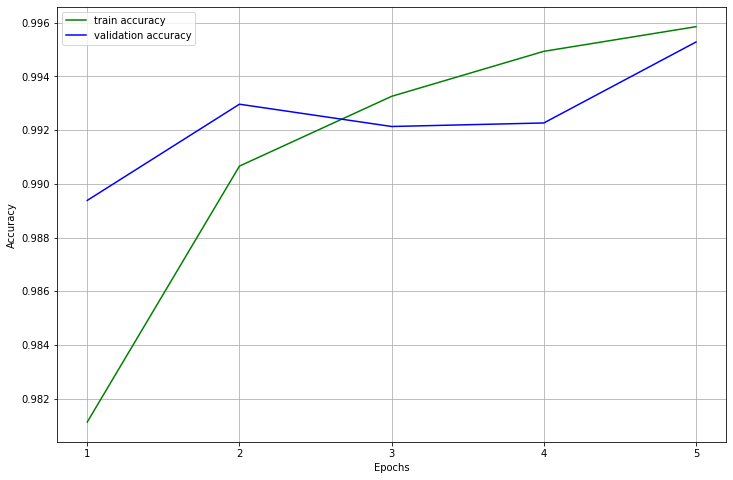

In [65]:
draw_fit_plots(ssftt_2)

#### Предсказание на ГСИ 1


In [66]:
pred_2_1 = ssftt_2.predict(X=hsi_1, y=mask_1)

pred_2_1 = pred_2_1 * (mask_1.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:05, 358.10it/s]                                                                    


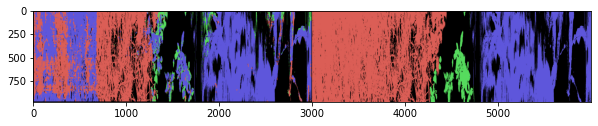

In [67]:
color_pred_2_1 = convert_to_color_(pred_2_1)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_2_1, convert_to_color_(mask_1.get_2d()))))
plt.show()

In [72]:
report = classification_report(pred_2_1.flatten(), mask_1.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.965322  0.982355  9.997610e+05
1              0.624644  0.956497  0.755746  7.643990e+05
2              0.327176  0.349192  0.337826  9.155700e+04
3              0.891991  0.577888  0.701379  1.072283e+06
accuracy       0.801867  0.801867  0.801867  8.018671e-01
macro avg      0.710953  0.712225  0.694326  2.928000e+06
weighted avg   0.841414  0.801867  0.800143  2.928000e+06

#### Предсказание на ГСИ 2


In [68]:
pred_2_2 = ssftt_2.predict(X=hsi_2, y=mask_2)

pred_2_2 = pred_2_2 * (mask_2.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:06, 355.59it/s]                                                                    


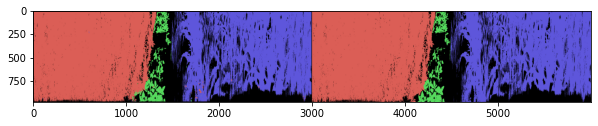

In [69]:
color_pred_2_2 = convert_to_color_(pred_2_2)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_2_2, convert_to_color_(mask_2.get_2d()))))
plt.show()

In [73]:
report = classification_report(pred_2_2.flatten(), mask_2.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.951197  0.974988  6.359390e+05
1              0.983101  0.996731  0.989869  1.162306e+06
2              0.968643  0.947046  0.957723  8.024000e+04
3              0.983710  0.999372  0.991479  1.049515e+06
accuracy       0.986427  0.986427  0.986427  9.864266e-01
macro avg      0.983863  0.973587  0.978515  2.928000e+06
weighted avg   0.986593  0.986427  0.986333  2.928000e+06

#### Предсказание на ГСИ 3

In [70]:
pred_2_3 = ssftt_2.predict(X=hsi_3, y=mask_3)

pred_2_3 = pred_2_3 * (mask_3.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:05, 359.88it/s]                                                                    


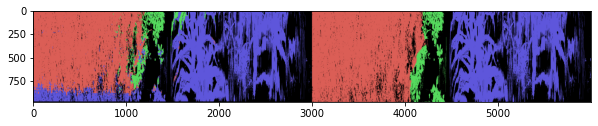

In [71]:
color_pred_2_3 = convert_to_color_(pred_2_3)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_2_3, convert_to_color_(mask_3.get_2d()))))
plt.show()

In [74]:
report = classification_report(pred_2_3.flatten(), mask_3.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.972407  0.986010  9.895140e+05
1              0.846470  0.986184  0.911001  8.725320e+05
2              0.616854  0.676024  0.645085  1.120700e+05
3              0.969058  0.839569  0.899678  9.538840e+05
accuracy       0.921892  0.921892  0.921892  9.218921e-01
macro avg      0.858095  0.868546  0.860444  2.928000e+06
weighted avg   0.929503  0.921892  0.922483  2.928000e+06

### ГСИ_3

In [75]:
optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}


fit_params = {
    "epochs": 5,
    "train_sample_percentage": 0.1,
    "dataloader_mode": "fixed",
    "optimizer_params": optimizer_params,
    "batch_size": 256,
}

In [76]:
ssftt_3 = SSFTT(n_classes=mask_3.n_classes, # количество классов можно вытащить из объекта маски
                n_bands=30, # количество каналов входного ГСИ
                device='cuda')

In [77]:
ssftt_3.fit(X=hsi_3, 
            y=mask_3, 
            fit_params=fit_params)

PCA will not apply
Sampling fixed with train size = 0.1
Sampling fixed with train size = 0.9


Train loop: 100%|█| 5/5 [03:22<00:00, 40.47s/it, train accuracy: 0.995742092457421	val accuracy: 0.9964823340748021	tra


#### Предсказание на ГСИ 1

In [78]:
pred_3_1 = ssftt_3.predict(X=hsi_1, y=mask_1)

pred_3_1 = pred_3_1 * (mask_1.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:04, 360.74it/s]                                                                    


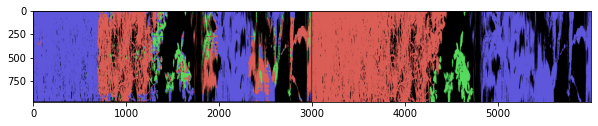

In [79]:
color_pred_3_1 = convert_to_color_(pred_3_1)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_3_1, convert_to_color_(mask_1.get_2d()))))
plt.show()

In [88]:
report = classification_report(pred_3_1.flatten(), mask_1.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.965322  0.982355  9.997610e+05
1              0.358797  0.636542  0.458917  6.597700e+05
2              0.483330  0.317622  0.383334  1.486990e+05
3              0.571877  0.354786  0.437903  1.119770e+06
accuracy       0.624853  0.624853  0.624853  6.248535e-01
macro avg      0.603501  0.568568  0.565627  2.928000e+06
weighted avg   0.665548  0.624853  0.625769  2.928000e+06

#### Предсказание на ГСИ 2

In [82]:
pred_3_2 = ssftt_3.predict(X=hsi_2, y=mask_2)

pred_3_2 = pred_3_2 * (mask_2.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:06, 355.37it/s]                                                                    


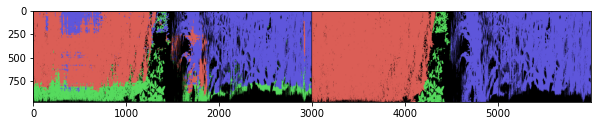

In [83]:
color_pred_3_2 = convert_to_color_(pred_3_2)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_3_2, convert_to_color_(mask_2.get_2d()))))
plt.show()

In [89]:
report = classification_report(pred_3_2.flatten(), mask_2.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.951197  0.974988  6.359390e+05
1              0.734530  0.923068  0.818077  9.377270e+05
2              0.787026  0.170639  0.280468  3.618340e+05
3              0.828427  0.889965  0.858094  9.925000e+05
accuracy       0.824973  0.824973  0.824973  8.249734e-01
macro avg      0.837496  0.733717  0.732907  2.928000e+06
weighted avg   0.830504  0.824973  0.799285  2.928000e+06

#### Предсказание на ГСИ 3

In [84]:
pred_3_3 = ssftt_3.predict(X=hsi_3, y=mask_3)

pred_3_3 = pred_3_3 * (mask_3.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:06, 356.18it/s]                                                                    


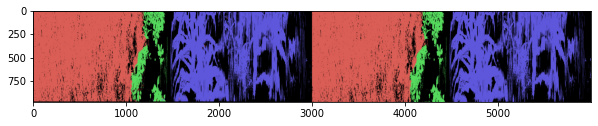

In [85]:
color_pred_3_3 = convert_to_color_(pred_3_3)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_3_3, convert_to_color_(mask_3.get_2d()))))
plt.show()

In [90]:
report = classification_report(pred_3_3.flatten(), mask_3.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.972407  0.986010  9.895140e+05
1              0.982277  0.995130  0.988662  1.003419e+06
2              0.944081  0.987422  0.965265  1.174290e+05
3              0.988656  0.999277  0.993938  8.176380e+05
accuracy       0.988300  0.988300  0.988300  9.882995e-01
macro avg      0.978753  0.988559  0.983469  2.928000e+06
weighted avg   0.988516  0.988300  0.988301  2.928000e+06

### Как видно из полученных данных, различие в освещении влияет на предсказательную способность моделей. 

#### Одним из вариантов решения, может быть усреднение весов обученных моделей

In [92]:
ssftt_mean = SSFTT(n_classes=mask_1.n_classes,
                   n_bands=30,
                   device='cuda')

Получим веса каждой из моделей и усредним их

In [93]:
sd_1 = ssftt_1.model.state_dict()
sd_2 = ssftt_2.model.state_dict()
sd_3 = ssftt_3.model.state_dict()

In [97]:
sd_mean = dict()

In [98]:
for key in sd_1:
    sd_mean[key] = (sd_1[key] + sd_2[key] + sd_3[key]) / 3.0

Загрузим усредненные веса в модель

In [99]:
ssftt_mean.model.load_state_dict(sd_mean)

<All keys matched successfully>

#### Предсказание на ГСИ 1

In [100]:
pred_m_1 = ssftt_mean.predict(X=hsi_1, y=mask_1)

pred_m_1 = pred_m_1 * (mask_1.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:06, 355.31it/s]                                                                    


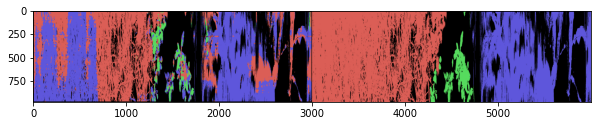

In [101]:
color_pred_m_1 = convert_to_color_(pred_m_1)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_m_1, convert_to_color_(mask_1.get_2d()))))
plt.show()

In [102]:
report = classification_report(pred_m_1.flatten(), mask_1.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.965322  0.982355  9.997610e+05
1              0.553974  0.758852  0.640426  8.544810e+05
2              0.389857  0.519005  0.445255  7.340200e+04
3              0.700482  0.486447  0.574166  1.000356e+06
accuracy       0.730270  0.730270  0.730270  7.302705e-01
macro avg      0.661078  0.682406  0.660551  2.928000e+06
weighted avg   0.752209  0.730270  0.729647  2.928000e+06

#### Предсказание на ГСИ 2

In [103]:
pred_m_2 = ssftt_mean.predict(X=hsi_2, y=mask_2)

pred_m_2 = pred_m_2 * (mask_2.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:05, 359.05it/s]                                                                    


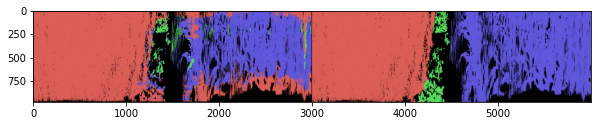

In [104]:
color_pred_m_2 = convert_to_color_(pred_m_2)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_m_2, convert_to_color_(mask_2.get_2d()))))
plt.show()

In [105]:
report = classification_report(pred_m_2.flatten(), mask_2.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.951197  0.974988  6.359390e+05
1              0.977368  0.809943  0.885814  1.422015e+06
2              0.329734  0.465034  0.385868  5.562600e+04
3              0.741018  0.970128  0.840235  8.144200e+05
accuracy       0.878625  0.878625  0.878625  8.786250e-01
macro avg      0.762030  0.799076  0.771726  2.928000e+06
weighted avg   0.904239  0.878625  0.883006  2.928000e+06

#### Предсказание на ГСИ 3

In [106]:
pred_m_3 = ssftt_mean.predict(X=hsi_3, y=mask_3)

pred_m_3 = pred_m_3 * (mask_3.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:10, 346.10it/s]                                                                    


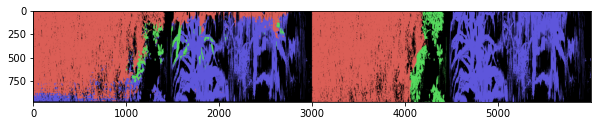

In [107]:
color_pred_m_3 = convert_to_color_(pred_m_3)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_m_3, convert_to_color_(mask_3.get_2d()))))
plt.show()

In [108]:
report = classification_report(pred_m_3.flatten(), mask_3.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.972407  0.986010  9.895140e+05
1              0.902567  0.875528  0.888842  1.047943e+06
2              0.301400  0.500264  0.376167  7.399700e+04
3              0.839878  0.850037  0.844927  8.165460e+05
accuracy       0.891675  0.891675  0.891675  8.916752e-01
macro avg      0.760962  0.799559  0.773986  2.928000e+06
weighted avg   0.902819  0.891675  0.896477  2.928000e+06

### Можно обучить на одном ГСИ и добавлять другие, как few-shot learning

In [109]:
optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}


fit_params = {
    "epochs": 10,
    "train_sample_percentage": 0.1,
    "dataloader_mode": "fixed",
    "optimizer_params": optimizer_params,
    "batch_size": 256,
}

In [110]:
ssftt_few = SSFTT(n_classes=mask_1.n_classes,
                  n_bands=30,
                  device='cuda')

In [111]:
ssftt_few.fit(X=hsi_1, 
              y=mask_1, 
              fit_params=fit_params)

PCA will not apply
Sampling fixed with train size = 0.1
Sampling fixed with train size = 0.9


Train loop: 100%|█| 10/10 [06:41<00:00, 40.20s/it, train accuracy: 0.9993884462496178	val accuracy: 0.9983391290808118	


дообучим модель на небольшом количестве данных и одной эпохе из других ГСИ

Дообучаем на 1% ГСИ 2

In [113]:
optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}


fit_params = {
    "epochs": 1,
    "train_sample_percentage": 0.01,
    "dataloader_mode": "fixed",
    "optimizer_params": optimizer_params,
    "batch_size": 256,
}
ssftt_few.fit(X=hsi_2, 
              y=mask_2, 
              fit_params=fit_params)

PCA will not apply
Sampling fixed with train size = 0.01
Sampling fixed with train size = 0.9


Train loop: 100%|█| 1/1 [00:04<00:00,  4.90s/it, train accuracy: 0.9500825483150432	val accuracy: 0.9668556476232011	tr


Дообучаем на 1% ГСИ 3

In [114]:
optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}


fit_params = {
    "epochs": 1,
    "train_sample_percentage": 0.01,
    "dataloader_mode": "fixed",
    "optimizer_params": optimizer_params,
    "batch_size": 256,
}
ssftt_few.fit(X=hsi_3, 
              y=mask_3, 
              fit_params=fit_params)

PCA will not apply
Sampling fixed with train size = 0.01
Sampling fixed with train size = 0.9


Train loop: 100%|█| 1/1 [00:04<00:00,  4.12s/it, train accuracy: 0.9635925117721373	val accuracy: 0.9824561403508771	tr


#### Предсказание на ГСИ 1

In [115]:
pred_f_1 = ssftt_few.predict(X=hsi_1, y=mask_1)

pred_f_1 = pred_m_1 * (mask_1.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:03, 363.46it/s]                                                                    


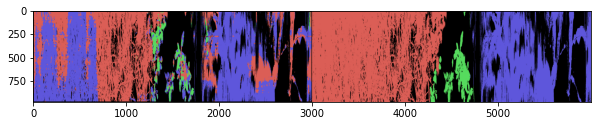

In [116]:
color_pred_f_1 = convert_to_color_(pred_f_1)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_f_1, convert_to_color_(mask_1.get_2d()))))
plt.show()

In [117]:
report = classification_report(pred_f_1.flatten(), mask_1.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.965322  0.982355  9.997610e+05
1              0.553974  0.758852  0.640426  8.544810e+05
2              0.389857  0.519005  0.445255  7.340200e+04
3              0.700482  0.486447  0.574166  1.000356e+06
accuracy       0.730270  0.730270  0.730270  7.302705e-01
macro avg      0.661078  0.682406  0.660551  2.928000e+06
weighted avg   0.752209  0.730270  0.729647  2.928000e+06

#### Предсказание на ГСИ 2

In [121]:
pred_f_2 = ssftt_few.predict(X=hsi_2, y=mask_2)

pred_f_2 = pred_f_2 * (mask_2.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:10, 344.26it/s]                                                                    


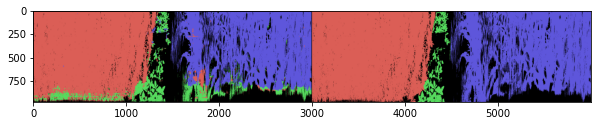

In [122]:
color_pred_f_2 = convert_to_color_(pred_f_2)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_f_2, convert_to_color_(mask_2.get_2d()))))
plt.show()

In [123]:
report = classification_report(pred_f_2.flatten(), mask_2.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.951197  0.974988  6.359390e+05
1              0.934829  0.974667  0.954332  1.130255e+06
2              0.883074  0.315111  0.464479  2.198530e+05
3              0.878192  0.994052  0.932537  9.419530e+05
accuracy       0.926282  0.926282  0.926282  9.262818e-01
macro avg      0.924024  0.808756  0.831584  2.928000e+06
weighted avg   0.926877  0.926282  0.915026  2.928000e+06

#### Предсказание на ГСИ 3

In [124]:
pred_f_3 = ssftt_few.predict(X=hsi_3, y=mask_3)

pred_f_3 = pred_f_3 * (mask_3.get_2d() > 0)

PCA will not apply


Inference on the image: 45007it [02:12, 340.12it/s]                                                                    


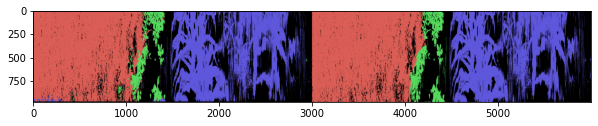

In [125]:
color_pred_f_3 = convert_to_color_(pred_f_3)

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((color_pred_f_3, convert_to_color_(mask_3.get_2d()))))
plt.show()

In [126]:
report = classification_report(pred_f_3.flatten(), mask_3.get_2d().flatten(),  output_dict=True)
pd.DataFrame(report).transpose()

precision    recall  f1-score       support
0              1.000000  0.972407  0.986010  9.895140e+05
1              0.967957  0.984876  0.976343  9.990850e+05
2              0.833179  0.909665  0.869744  1.124930e+05
3              0.986264  0.985684  0.985974  8.269080e+05
accuracy       0.978001  0.978001  0.978001  9.780007e-01
macro avg      0.946850  0.963158  0.954518  2.928000e+06
weighted avg   0.978778  0.978001  0.978235  2.928000e+06